# Brain Tumor Detection Using a Convolutional Neural Network

In [1]:
import tensorflow as tf
import tf_keras
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , precision_score
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import keras
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

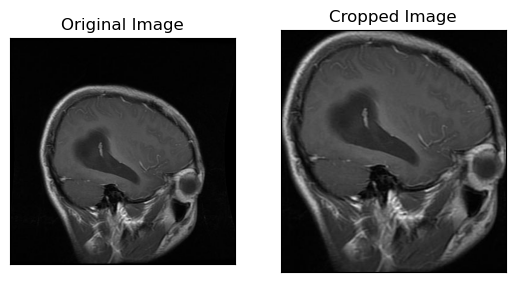

In [6]:
ex_img = cv2.imread('brain-tumor-mri-dataset/Testing/glioma/Te-gl_0202.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [8]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them in a memory-efficient way.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple of (image_width, image_height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, 3).
        y: A numpy array with shape = (#_examples,).
    """
    X = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            file_path = f"{directory}/{filename}"
            
            # Load the image
            image = cv2.imread(file_path)
            if image is None:
                continue

            # Resize the image
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize the image
            image = image / 255.0

            # Append the processed image
            X.append(image)

            # Assign labels based on folder name
            folder_name = directory.split('/')[-1].lower()
            if folder_name == 'glioma':
                y.append(0)
            elif folder_name == 'meningioma':
                y.append(1)
            elif folder_name == 'notumor':
                y.append(2)
            elif folder_name == 'pituitary':
                y.append(3)

    # Convert lists to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Shuffle the data
    # X, y = shuffle(X, y, random_state=42)

    print(f'Number of examples: {len(X)}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    return X, y

In [9]:
training_path = 'brain-tumor-mri-dataset/Training/'
glioma = training_path + 'glioma' 
meningioma = training_path + 'meningioma'
notumor = training_path + 'notumor'
pituitary = training_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (299, 299)
X, y = load_data([glioma, meningioma , notumor , pituitary], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 5712
X shape: (5712, 299, 299, 3)
y shape: (5712,)


In [10]:
testing_path = 'brain-tumor-mri-dataset/Testing/'
glioma_test = testing_path + 'glioma' 
meningioma_test = testing_path + 'meningioma'
notumor_test = testing_path + 'notumor'
pituitary_test = testing_path + 'pituitary'
IMG_WIDTH, IMG_HEIGHT = (299, 299)
X_test, y_test = load_data([glioma_test, meningioma_test , notumor_test , pituitary_test], (IMG_WIDTH, IMG_HEIGHT) )

Number of examples: 1311
X shape: (1311, 299, 299, 3)
y shape: (1311,)


In [17]:
y = y.reshape(-1 , 1)

In [19]:
y

array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]], dtype=int32)

In [9]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1,2,3]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "glioma" if label == 1 else "meningioma" if label == 2 else "notumor" if label == 3 else "pituitary"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

### Plot sample images:

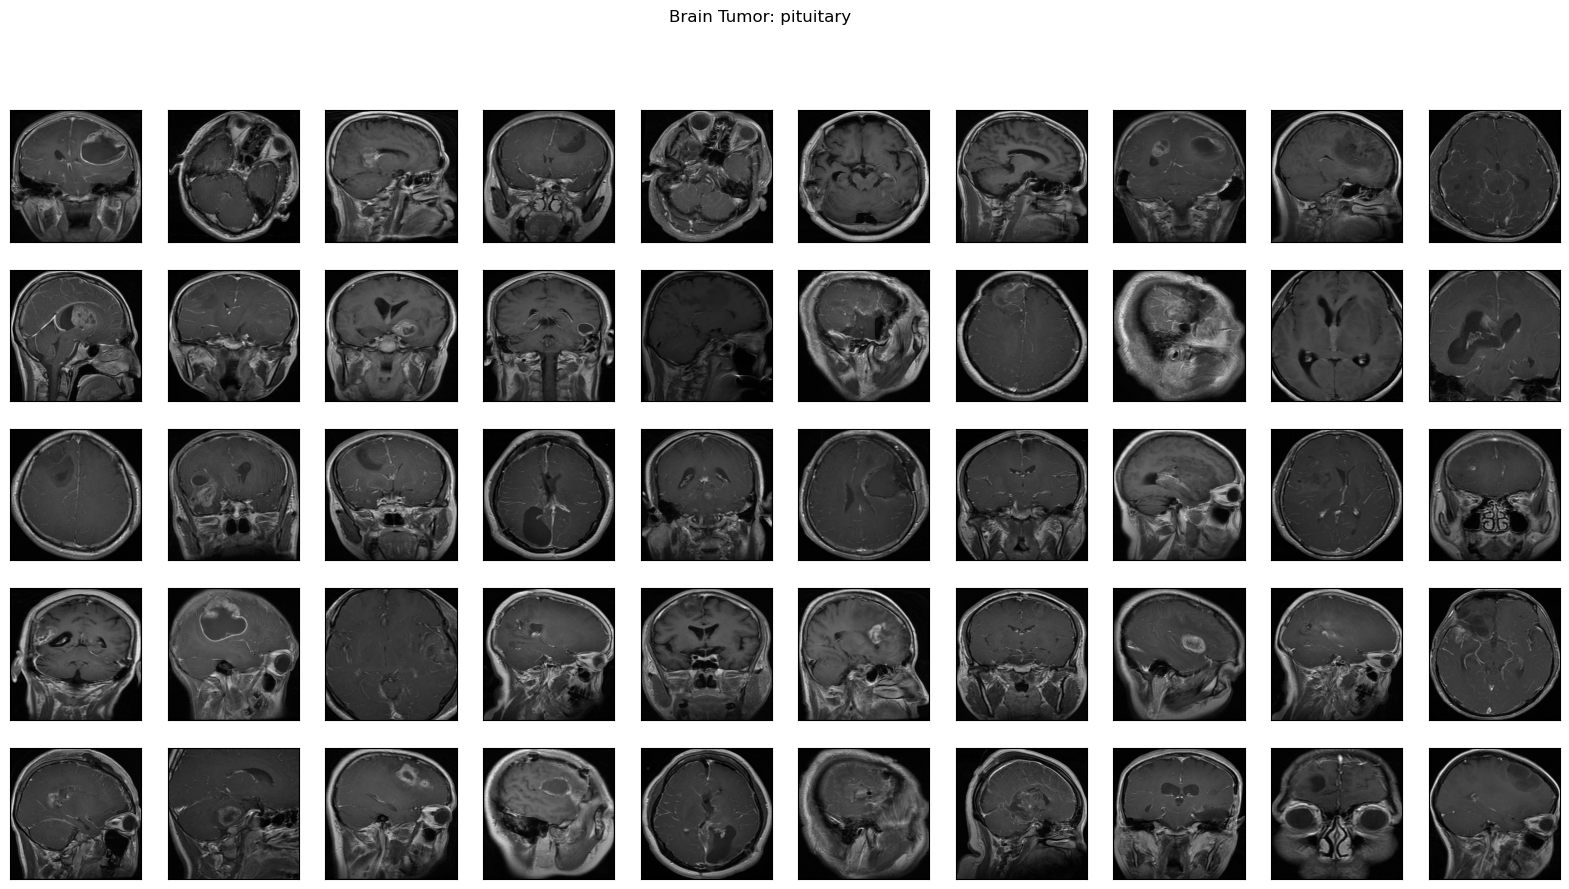

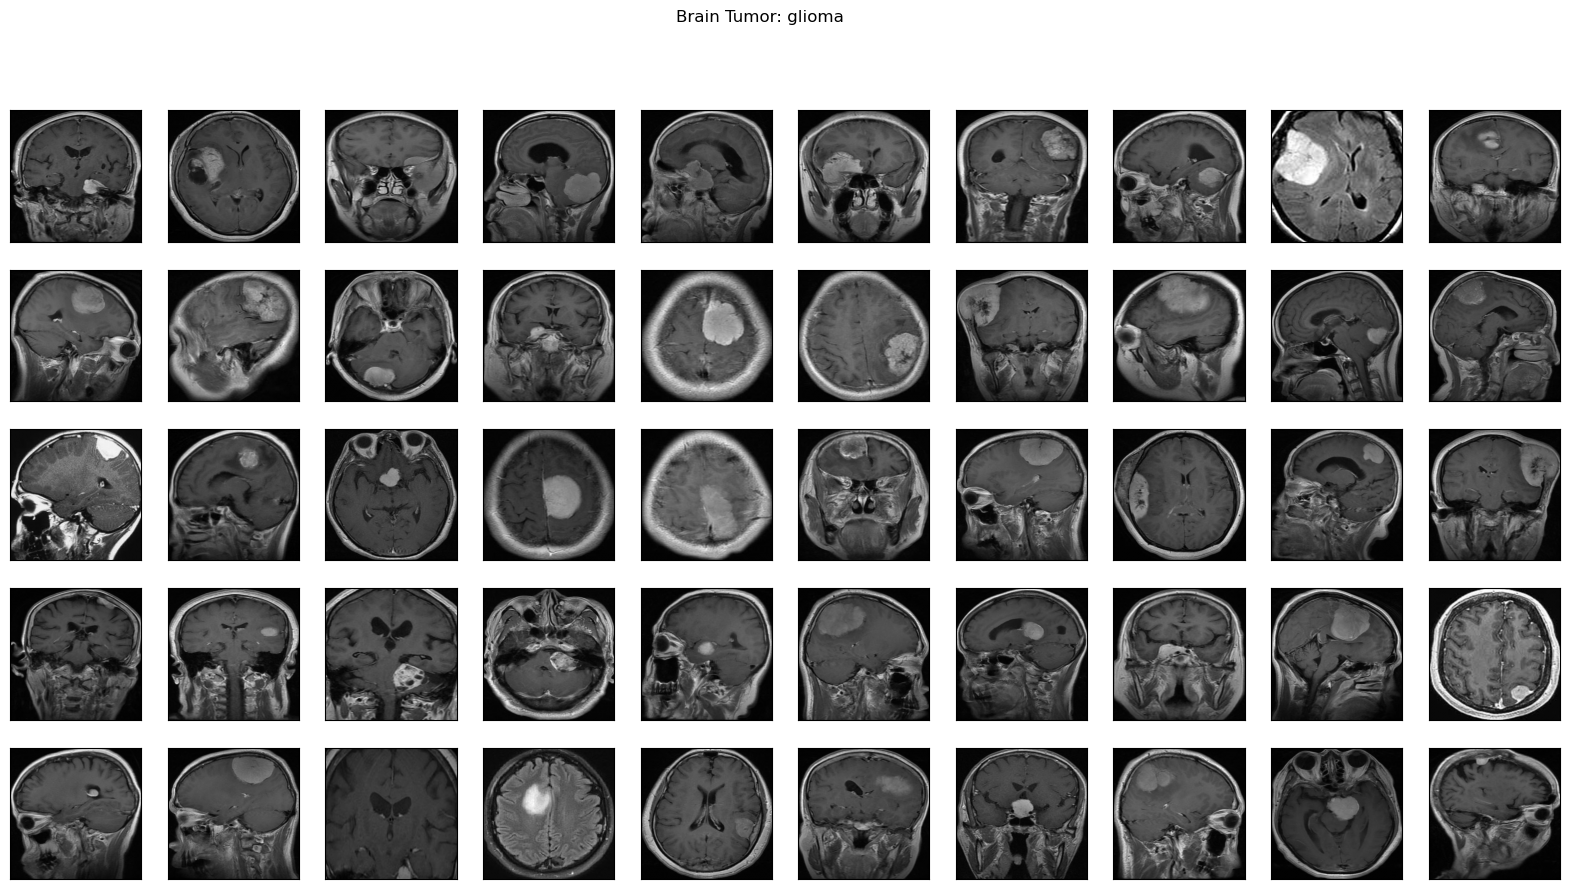

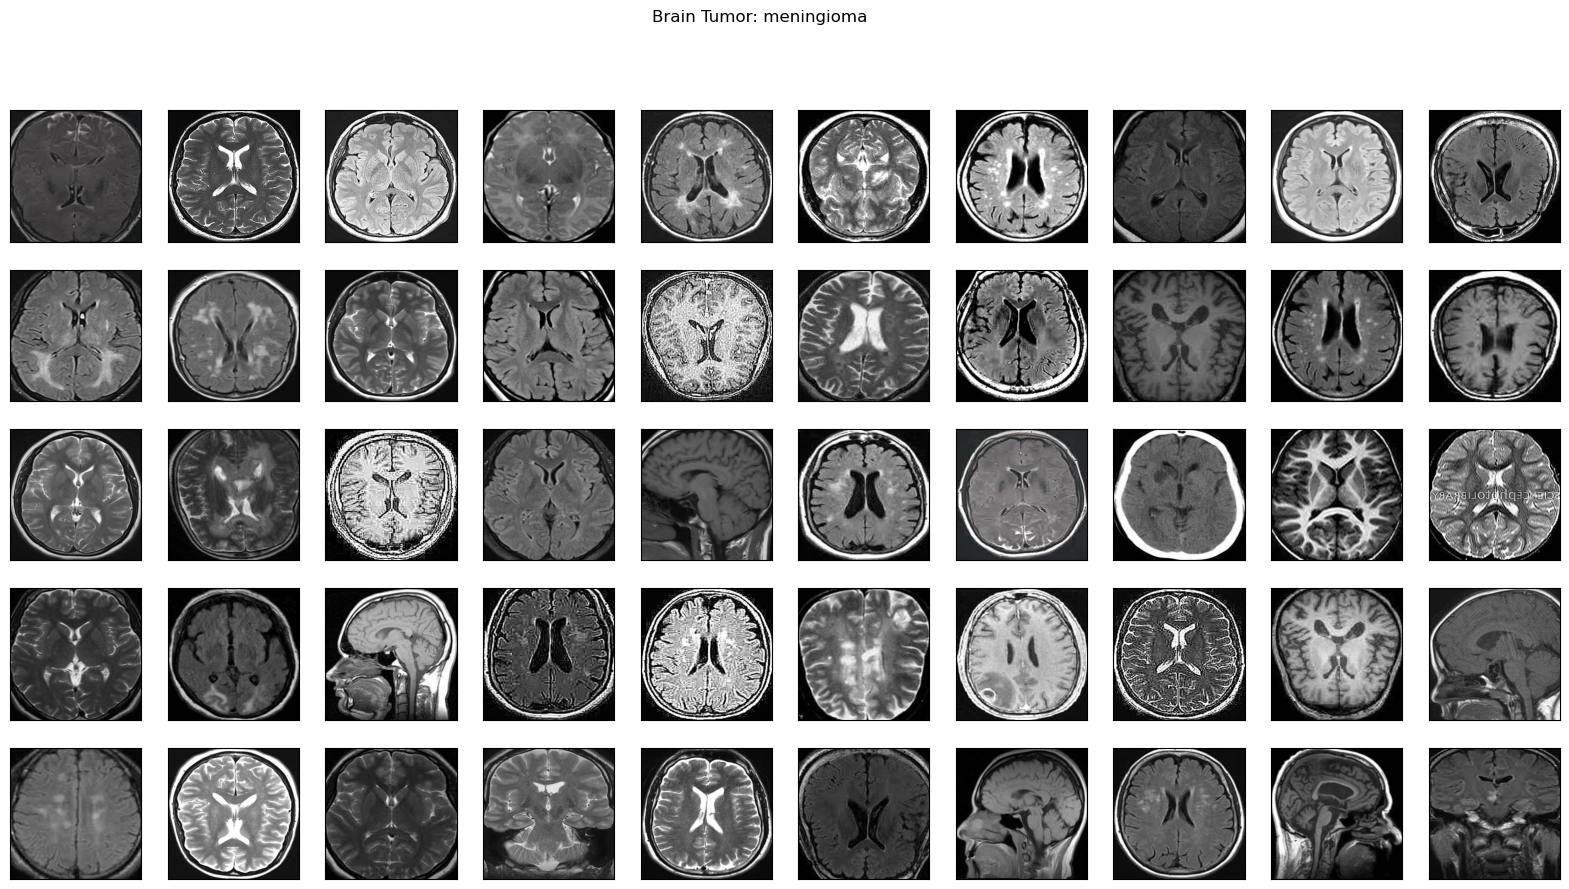

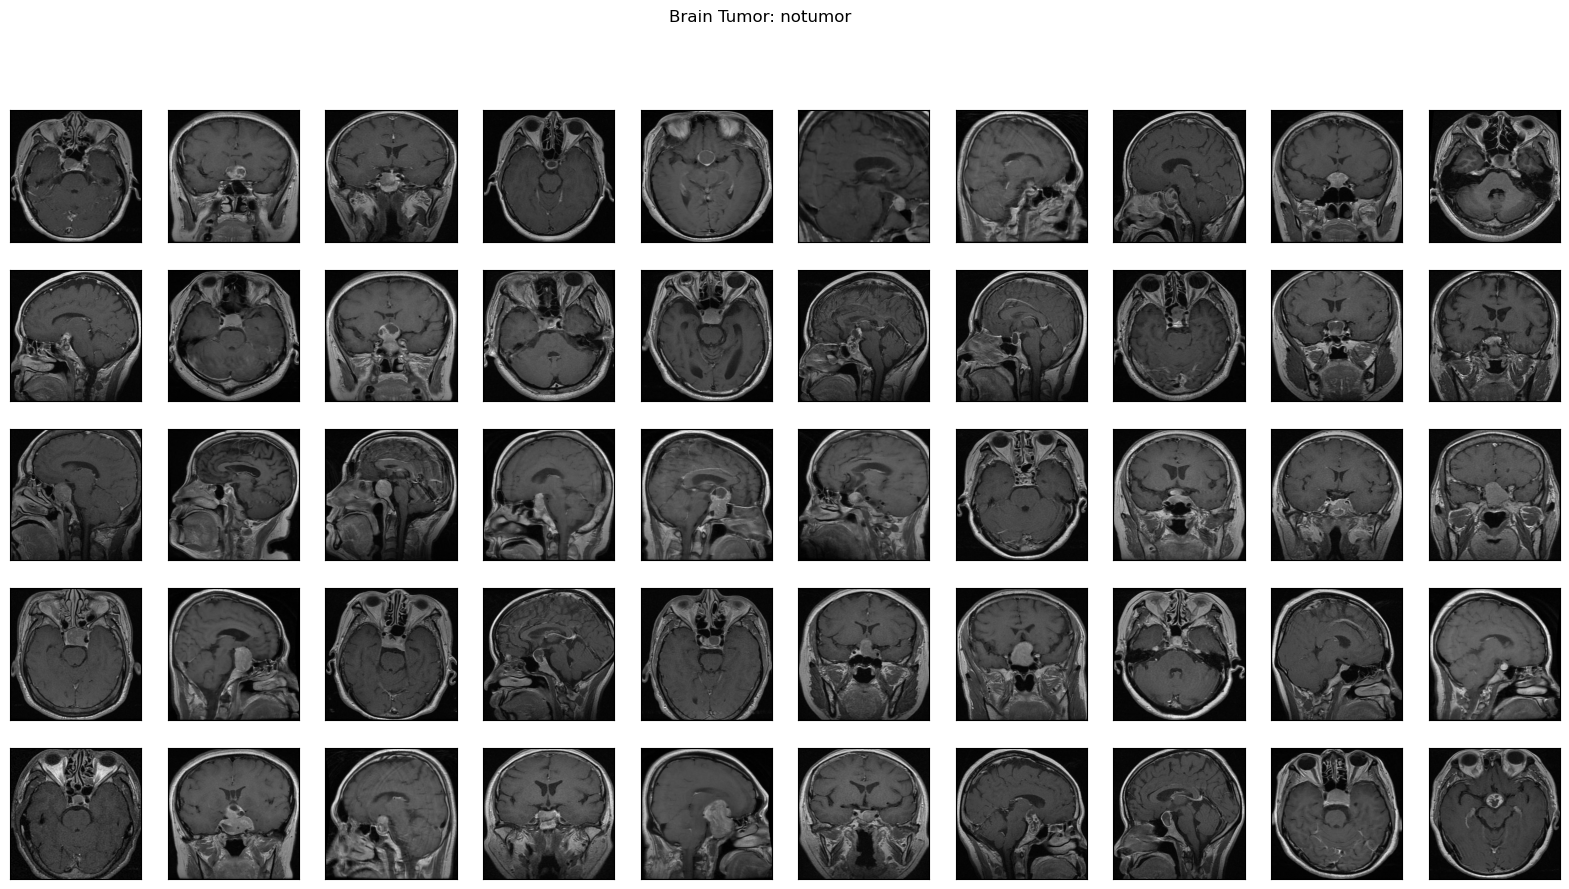

In [10]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [21]:
def split_data(X_test, y_test, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    y_test = y_test.reshape(-1, 1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

    return X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [24]:
X_val, y_val, X_test, y_test = split_data(X_test, y_test)

In [26]:
y = y.reshape(-1 ,1)

In [28]:
print ("number of training examples = " + str(X.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X.shape))
print ("Y_train shape: " + str(y.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 5712
number of development examples = 656
number of test examples = 655
X_train shape: (5712, 299, 299, 3)
Y_train shape: (5712, 1)
X_val (dev) shape: (656, 299, 299, 3)
Y_val (dev) shape: (656, 1)
X_test shape: (655, 299, 299, 3)
Y_test shape: (655, 1)


Some helper functions:

In [30]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [32]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [34]:
 def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the mode
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
 
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(512, activation= 'relu' , name ='Fully_connectedz_layer')(X)
    X = Dropout(0.5)(X)
    X = Dense(512, activation= 'relu' , name ='Fully_connectedz_layer_2')(X)
    X = Dense(4, activation='softmax', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this 
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [37]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [39]:
model = build_model(IMG_SHAPE)

In [41]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 303, 303, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 297, 297, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 297, 297, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 297, 297, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fully_connectedz_layer (Dense)  │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fully_connectedz_layer_2        │ (None, 512)            │       262,656 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,891,780 (41.55 MB)

 Trainable params: 10,891,652 (41.55 MB)

 Non-trainable params: 128 (512.00 B)

Compile the model:

In [44]:
model.compile(optimizer=Adamax(learning_rate = 0.0001), loss='SparseCategoricalCrossentropy', metrics = ['accuracy'])

In [46]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [48]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [53]:
start_time = time.time()

history=model.fit(x=X, y=y, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.8248 - loss: 0.4760 - val_accuracy: 0.7851 - val_loss: 0.5165
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.8145 - loss: 0.4476 - val_accuracy: 0.8232 - val_loss: 0.4345
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.8387 - loss: 0.4155 - val_accuracy: 0.8216 - val_loss: 0.4088
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.8510 - loss: 0.3740 - val_accuracy: 0.8415 - val_loss: 0.3927
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.8645 - loss: 0.3611 - val_accuracy: 0.8293 - val_loss: 0.3804
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8777 - loss: 0.3196 - val_accuracy: 0.8902 - val_loss: 0.2966
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8831 - loss: 0.2977 - val_accuracy: 0.8720 - val_loss: 0.3194
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.8933 - loss: 0.2770 - val_accu

Let's train for a few more epochs:

In [57]:
history = model.history.history

In [59]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

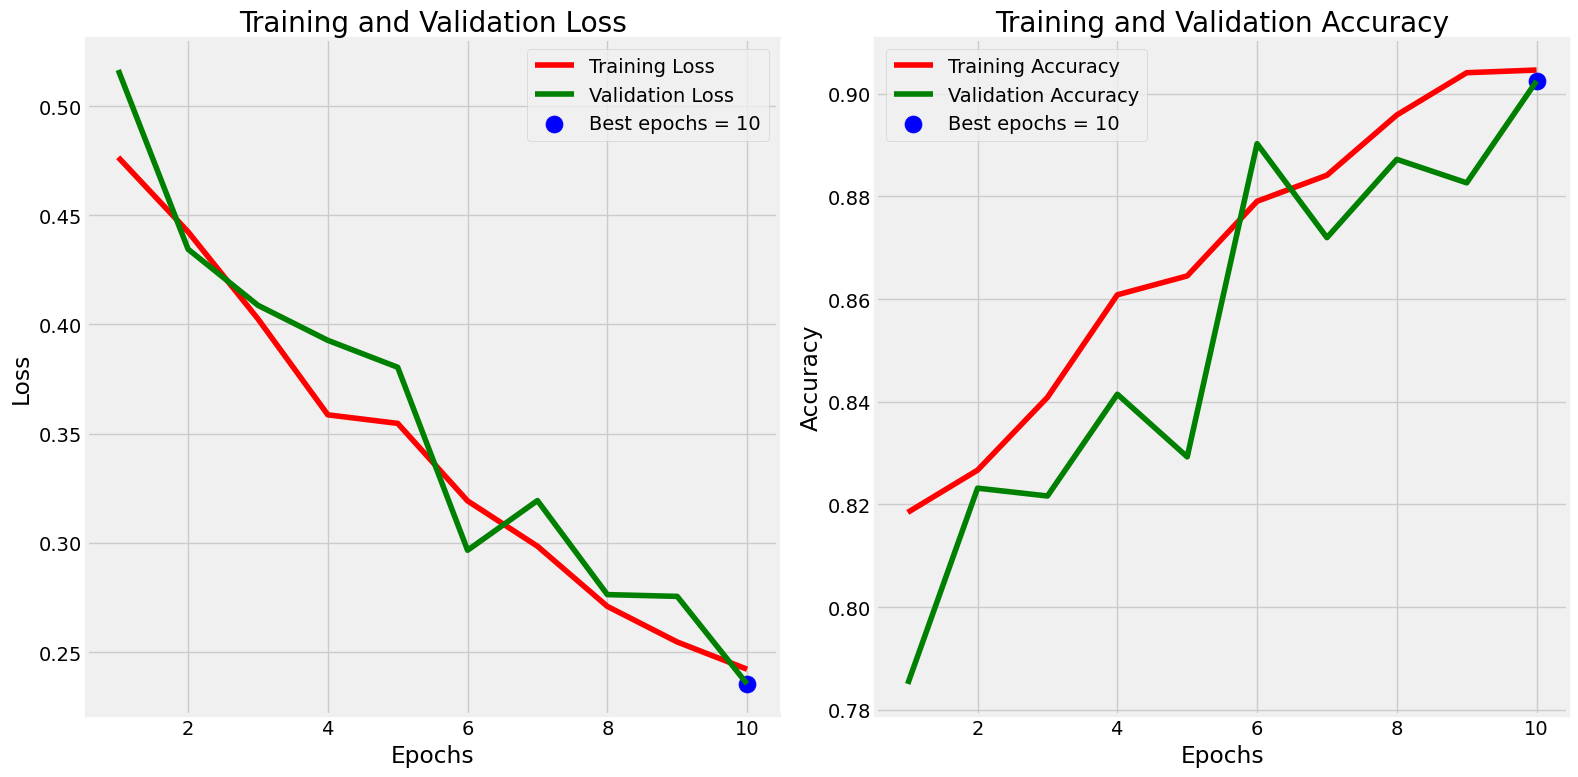

In [62]:
train_acc = history['accuracy']
train_loss = history['loss']

val_acc = history['val_accuracy']
val_loss = history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(16,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('visulize_fr_CNN')
plt.legend()
plt.savefig('Brain_tumor_CN')
plt.tight_layout()
plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [64]:
best_model = keras.models.load_model(filepath='models/cnn-parameters-improvement-10-0.90.model.keras')

In [66]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [69]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.9131 - loss: 0.2222 


### Accuracy of the best model on the testing data:

In [72]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.22069759666919708
Test Accuracy = 0.9114503860473633


### F1 score for the best model on the testing data:

In [75]:
y_test_prob = best_model.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 299, 299, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step


In [76]:
f1score = f1_score(y_test, np.argmax(y_test_prob , axis=1), average='micro')
print(f"F1 score: {f1score}")

F1 score: 0.9114503816793893


Let's also find the f1 score on the validation data:

In [78]:
y_val_prob = best_model.predict(X_val)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step


In [79]:
y_pred = np.argmax(y_test_prob , axis=1)

In [80]:
f1score_val = f1_score(y_val, np.argmax(y_val_prob , axis=1), average='micro')
print(f"F1 score: {f1score_val}")

F1 score: 0.9024390243902439


In [81]:
f1score

0.9114503816793893

In [82]:
recall = recall_score(y_test , np.argmax(y_test_prob , axis=1), average='micro')
recall

0.9114503816793893

In [83]:
precision = precision_score(y_test , np.argmax(y_test_prob , axis=1), average='micro')
precision

0.9114503816793893

In [84]:
print("\nClassification Report:\n", classification_report(y_test, y_pred , target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


Classification Report:
               precision    recall  f1-score   support

      Glioma       0.90      0.87      0.89       158
  Meningioma       0.83      0.79      0.81       146
    No Tumor       0.94      0.98      0.96       192
   Pituitary       0.95      0.97      0.96       159

    accuracy                           0.91       655
   macro avg       0.91      0.91      0.91       655
weighted avg       0.91      0.91      0.91       655



### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [87]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[138  20   0   0]
 [ 12 115  11   8]
 [  1   2 189   0]
 [  2   2   0 155]]


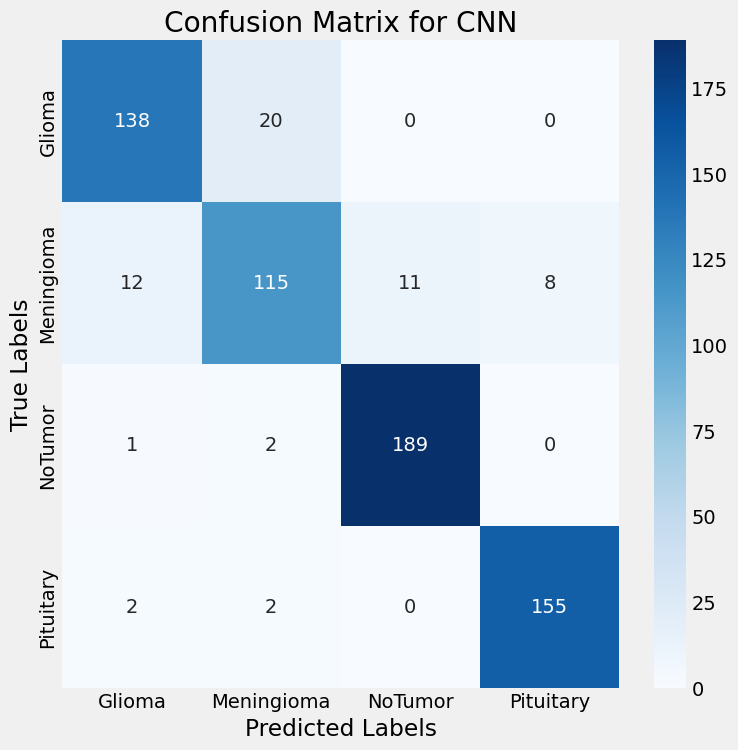

In [88]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'NoTumor', 'Pituitary'], yticklabels=['Glioma', 'Meningioma', 'NoTumor', 'Pituitary'])
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('Confusion Matrix for CNN')
plt.show()


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**91.2%** accuracy on the **test set**.<br>
**0.91** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 91.2%      |
| F1 score  | 0.91           | 0.91     |

Hooray!